In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
import string
import networkx as nx
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
def check_kw_freq(df, kws: list, op = 'or', attr = 'JOB_DESCRIPTION', verbose = False):
    
    kw_booltable = df[attr].str.contains(kws[0])
    for i in range(1, len(kws)):
        if op == 'or':
            kw_booltable =   kw_booltable | df[attr].str.contains(kws[i])
        else:
            kw_booltable =   kw_booltable & df[attr].str.contains(kws[i])
    
    if verbose:
        return kw_booltable
    else:
        return kw_booltable.sum()

In [3]:
def check_kw_freq_v2(df, kws: list, op = 'or', attr = 'JOB_DESCRIPTION'):
    
    kw_booltable = df[attr].str.contains(kws[0]).astype(int)
    for i in range(1, len(kws)):
        if op == 'or':
            kw_booltable =   kw_booltable + df[attr].str.contains(kws[i]).astype(int)
        else:
            kw_booltable =   kw_booltable * df[attr].str.contains(kws[i]).astype(int)
    
    return kw_booltable

In [101]:
def dict_freq_sort(d, thresh = 1):
    return sorted([(c,d[c]) for c in d if d[c] > thresh], key = lambda x:x[1], reverse = True)


In [4]:
postings_data = pd.read_csv('../social_datathon_0/UK_Postings_Sample.csv', low_memory=False)

In [5]:
postings_data.columns

Index([' ', 'POSTED', 'TITLE_NAME', 'SOC_4', 'SOC_4_NAME', 'SOC_3',
       'SOC_3_NAME', 'SOC_2', 'SOC_2_NAME', 'LOT_OCCUPATION_NAME',
       'LOT_CAREER_AREA_NAME', 'CITY_NAME', 'NUTS1_NAME', 'NUTS3_NAME',
       'TTWA_NAME', 'COUNTRY_NAME', 'COMPANY_NAME', 'COMPANY_IS_STAFFING',
       'UK_SIC_2', 'INDUSTRY', 'IS_INTERNSHIP', 'IS_REMOTE',
       'SPECIALIZED_SKILLS_NAME', 'COMMON_SKILLS_NAME', 'SOFTWARE_SKILLS_NAME',
       'CERTIFICATIONS_NAME', 'EDULEVELS_NAME_MIN', 'SALARY',
       'JOB_DESCRIPTION'],
      dtype='object')

In [6]:
for sk in ['SPECIALIZED_SKILLS_NAME', 'COMMON_SKILLS_NAME','SOFTWARE_SKILLS_NAME' ]:
    postings_data[sk] = postings_data[sk].astype(str)

postings_data['POSTED'] = pd.to_datetime(postings_data['POSTED'])
postings_data['JOB_DESCRIPTION'] = postings_data['JOB_DESCRIPTION'].str.lower()

In [7]:
postings_data= postings_data[~postings_data['JOB_DESCRIPTION'].isnull()]

In [8]:
N_jobs, N_attr = postings_data.shape
print(N_jobs)

100000


In [9]:
green_skills = ['Green Building',  'Sustainability Reporting',
'Renewable Energy','Circular Economy',
'Sustainable Materials','Regenerative Design', 'Energy Trading',  'Sustainability Initiatives',
'Sustainable Design','Hydrogen Production', 'Environmental Laws',
'Sustainable Development','Emission Calculations', 'Wind Power','Nuclear Power', 'Climate Change Mitigation',
'Climate Variability And Change','Electric Vehicles','Climatology',
'Climate Policy','Renewable Energy Systems',  'Sustainable Business','Electric Vehicle (EV) Installation', 
 'Wind Farming', 'Wind Turbines', 'Environmental Science',
'Wind Turbine Maintenance','Low Carbon Development',  'Climate Resilience', 'Renewable Energy Markets','Environmental Justice',
     'Climate Modeling','Solar Energy Systems Installation','Sustainability Planning', 'Sustainability Procedures', 'Wind Turbine Technology',
        'Reforestation', 'Net Zero', 'Carbon Footprint Reduction', 'Carbon Accounting','Low Carbon Solutions','Greenhouse Gas', 'Carbon Offsets','Carbon Management', 'Carbon Markets',  'Carbon Capture And Storage']

In [10]:
green_skill_jobs =postings_data[postings_data.SPECIALIZED_SKILLS_NAME.str.contains('|'.join(green_skills))]

/var/folders/r1/0kzylldd4txdz1zgrvxrgpmh0000gn/T/ipykernel_34556/4206332261.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  green_skill_jobs =postings_data[postings_data.SPECIALIZED_SKILLS_NAME.str.contains('|'.join(green_skills))]


In [11]:
len(green_skill_jobs), len(green_skill_jobs)/N_jobs

(539, 0.00539)

In [12]:
spec_skill_green_skill_jobs_split = [(idx,s[4:-2].replace('"', '').split(',\n  ')) for (idx, s) in green_skill_jobs['SPECIALIZED_SKILLS_NAME'].items() if len(s) > 3 ]

In [13]:
green_skill_jobs_skill_counter = Counter([sk for joblst in spec_skill_green_skill_jobs_split for sk in joblst[1]])

In [14]:
green_skill_counter = {sk: green_skill_jobs_skill_counter[sk] for sk in green_skills}

In [15]:
prom_green_skills = [sk for sk in green_skill_counter if green_skill_counter[sk] > 2]

In [16]:
[(sk,green_skill_counter[sk]) for sk in prom_green_skills]

[('Green Building', 14),
 ('Sustainability Reporting', 7),
 ('Renewable Energy', 16),
 ('Circular Economy', 12),
 ('Energy Trading', 14),
 ('Sustainability Initiatives', 19),
 ('Sustainable Design', 6),
 ('Hydrogen Production', 8),
 ('Environmental Laws', 103),
 ('Sustainable Development', 29),
 ('Emission Calculations', 4),
 ('Wind Power', 6),
 ('Nuclear Power', 27),
 ('Climate Variability And Change', 9),
 ('Electric Vehicles', 83),
 ('Climatology', 4),
 ('Renewable Energy Systems', 3),
 ('Sustainable Business', 18),
 ('Wind Farming', 3),
 ('Wind Turbines', 11),
 ('Environmental Science', 78),
 ('Wind Turbine Maintenance', 3),
 ('Climate Resilience', 4),
 ('Solar Energy Systems Installation', 3),
 ('Sustainability Planning', 8),
 ('Net Zero', 70),
 ('Carbon Footprint Reduction', 14),
 ('Carbon Accounting', 5),
 ('Greenhouse Gas', 8),
 ('Carbon Offsets', 3),
 ('Carbon Management', 11),
 ('Carbon Markets', 3),
 ('Carbon Capture And Storage', 3)]

In [17]:
from networkx.algorithms import bipartite

In [18]:
B = nx.Graph()
B.add_nodes_from([e[0] for e in spec_skill_green_skill_jobs_split], bipartite=0)
B.add_nodes_from(set([sk for joblst in spec_skill_green_skill_jobs_split for sk in joblst[1]]), bipartite=1)
for e in spec_skill_green_skill_jobs_split:
    B.add_edges_from([(e[0], v) for v in e[1]])

In [19]:
skill_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 1}
P = bipartite.weighted_projected_graph(B, skill_nodes, ratio=False)

In [20]:
Green_skill_subgraph = P.subgraph([sk for sk in green_skill_counter if green_skill_counter[sk] > 2])
Green_skill_cc = max(nx.connected_components(Green_skill_subgraph ), key = len)

In [21]:
list(nx.connected_components(Green_skill_subgraph ))

[{'Carbon Accounting',
  'Carbon Footprint Reduction',
  'Carbon Management',
  'Carbon Markets',
  'Carbon Offsets',
  'Circular Economy',
  'Climate Resilience',
  'Climate Variability And Change',
  'Climatology',
  'Electric Vehicles',
  'Emission Calculations',
  'Environmental Laws',
  'Environmental Science',
  'Green Building',
  'Greenhouse Gas',
  'Net Zero',
  'Nuclear Power',
  'Renewable Energy',
  'Sustainability Initiatives',
  'Sustainability Planning',
  'Sustainability Reporting',
  'Sustainable Business',
  'Sustainable Design',
  'Sustainable Development',
  'Wind Power'},
 {'Renewable Energy Systems'},
 {'Wind Farming', 'Wind Turbine Maintenance', 'Wind Turbines'},
 {'Carbon Capture And Storage', 'Hydrogen Production'},
 {'Energy Trading'},
 {'Solar Energy Systems Installation'}]

In [25]:
pos = nx.kamada_kawai_layout(Green_skill_subgraph.subgraph(Green_skill_cc), weight=True)

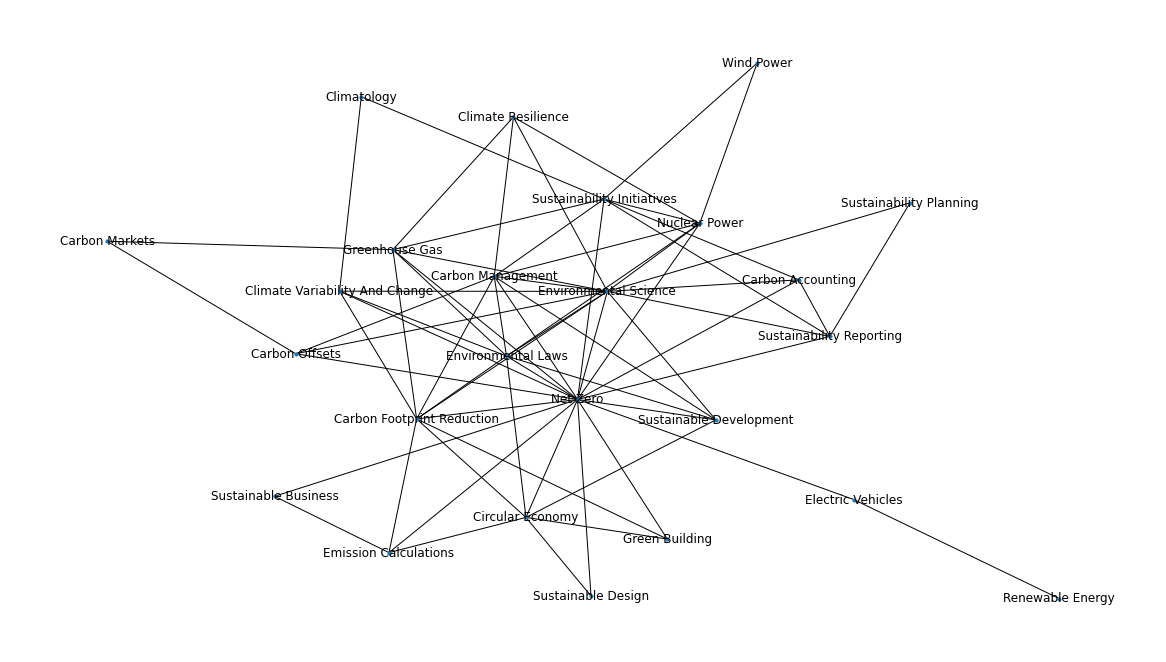

In [26]:
plt.figure(figsize= [16,9])

nx.draw(Green_skill_subgraph.subgraph(Green_skill_cc),pos= pos, node_size = 10, with_labels= True)

In [28]:
GB = B.edge_subgraph([e for e in B.edges() if e[1] in prom_green_skills])

In [43]:
GB_Mat = bipartite.biadjacency_matrix(GB, row_order = prom_green_skills)

In [44]:
GB_Cov_Mat = np.cov(GB_Mat.todense())

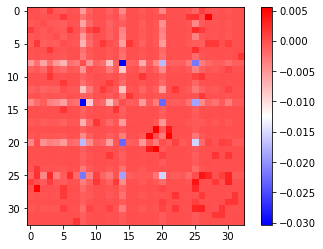

In [46]:
plt.imshow(GB_Cov_Mat - np.diag(np.diag(GB_Cov_Mat)),  cmap = 'bwr')
plt.colorbar()

In [62]:
r_idx, c_idx = np.where(GB_Cov_Mat - np.diag(np.diag(GB_Cov_Mat)) >1e-3)
Cov_Filt_GS_subgraph = Green_skill_subgraph.edge_subgraph([(prom_green_skills[r_idx[j]], prom_green_skills[c]) for j, c in enumerate(c_idx) if r_idx[j] > c])

In [63]:
Cov_Filt_GS_subgraph_maximal = Cov_Filt_GS_subgraph.subgraph(max(nx.connected_components(Cov_Filt_GS_subgraph), key = len))

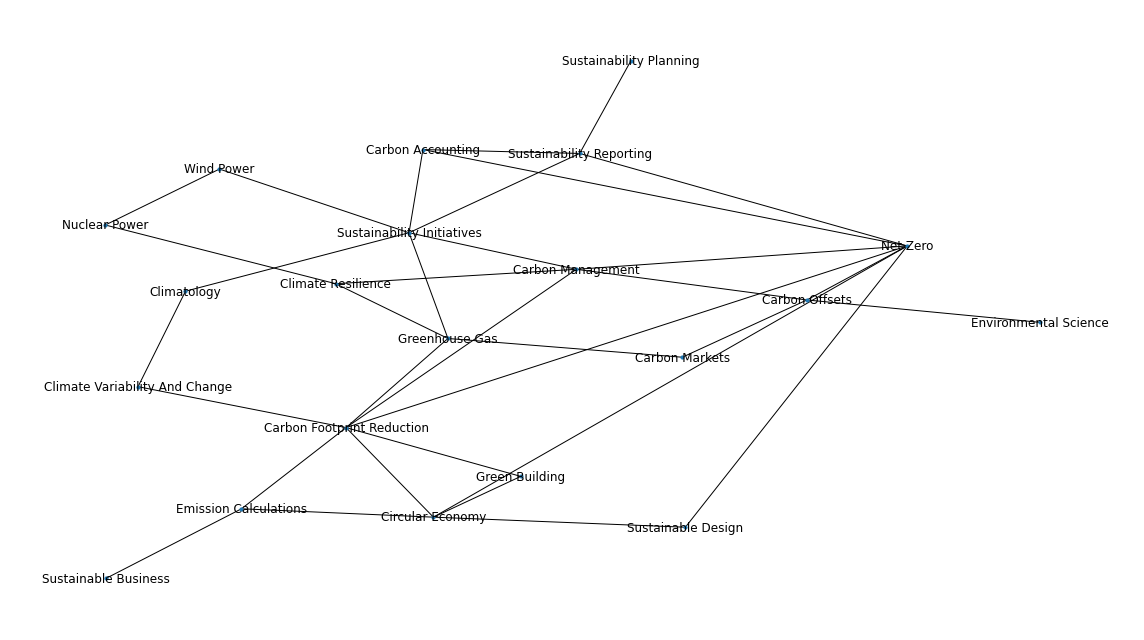

In [64]:
pos = nx.kamada_kawai_layout(Cov_Filt_GS_subgraph_maximal)
fig, ax = plt.subplots(1,1, figsize = [16,9])
nx.draw(Cov_Filt_GS_subgraph_maximal, node_size =10, pos= pos, with_labels= True, ax = ax)
fig.tight_layout()

In [138]:
spec_skills = postings_data['SPECIALIZED_SKILLS_NAME']
comm_skills = postings_data['COMMON_SKILLS_NAME']
sw_skills = postings_data['SOFTWARE_SKILLS_NAME']

In [139]:
spec_skill_split = [s[4:-2].replace('"', '').split(',\n  ') for s in spec_skills if len(s) > 3 ]
comm_skill_split = [s[4:-2].replace('"', '').split(',\n  ') for s in comm_skills if len(s) > 3 ]
sw_skill_split = [s[4:-2].replace('"', '').split(',\n  ') for s in sw_skills if len(s) > 3 ]

spec_skill_counts = Counter([sk for joblst in spec_skill_split for sk in joblst])
comm_skill_counts = Counter([sk for joblst in comm_skill_split for sk in joblst])
sw_skill_counts = Counter([sk for joblst in sw_skill_split for sk in joblst])

In [140]:
spec_skill_counts

Counter({'High-Performance Liquid Chromatography': 87,
         'Technical Services': 266,
         'Chromatography': 43,
         'Laboratory Equipment': 84,
         'Target Audience': 126,
         'Procurement': 2302,
         'Public Policies': 45,
         'Policy Development': 135,
         'Thought Leadership': 339,
         'Business Development': 2912,
         'Basic Safety Training': 2,
         'IBM Maximo': 42,
         'Statistical Analysis': 156,
         'Resource Allocation': 88,
         'System Administration': 261,
         'Performance Reporting': 228,
         'Help Desk Support': 637,
         'Health Assessment': 128,
         'Auditing': 4531,
         'Requirements Analysis': 146,
         'Usability': 161,
         'Invoicing': 2958,
         'Business Valuation': 133,
         'Acceptance Testing': 171,
         'Requirements Management': 158,
         'Feasibility Studies': 181,
         'Billing': 601,
         'SAP Applications': 1131,
         'Business

In [35]:
#Company level analysis

In [144]:
spec_skill_split = [(idx,s[4:-2].replace('"', '').split(',\n  ')) for (idx, s) in postings_data['SPECIALIZED_SKILLS_NAME'].items()]

skill_SOC3_counter = Counter([postings_data.loc[e[0]].SOC_3_NAME for e in spec_skill_split])
skill_SOC2_counter = Counter([postings_data.loc[e[0]].SOC_2_NAME for e in spec_skill_split])

skill_LOT_OCC_counter = Counter([postings_data.loc[e[0]].LOT_OCCUPATION_NAME for e in spec_skill_split])
skill_LOT_CAR_counter = Counter([postings_data.loc[e[0]].LOT_CAREER_AREA_NAME for e in spec_skill_split])
skill_TTWA_counter = Counter([postings_data.loc[e[0]].TTWA_NAME for e in spec_skill_split])
skill_CITY_counter = Counter([postings_data.loc[e[0]].CITY_NAME for e in spec_skill_split])


In [100]:
Green_skill_company_counter = Counter([green_skill_jobs.loc[e[0]].COMPANY_NAME for e in spec_skill_green_skill_jobs_split if green_skill_jobs.loc[e[0]].COMPANY_NAME != 'Unclassified'])

Green_skill_all_skill_count = Counter([sk for joblst in spec_skill_green_skill_jobs_split for sk in joblst[1]])

Green_skill_SOC3_counter = Counter([green_skill_jobs.loc[e[0]].SOC_3_NAME for e in spec_skill_green_skill_jobs_split])
Green_skill_SOC2_counter = Counter([green_skill_jobs.loc[e[0]].SOC_2_NAME for e in spec_skill_green_skill_jobs_split])

Green_skill_LOT_OCC_counter = Counter([green_skill_jobs.loc[e[0]].LOT_OCCUPATION_NAME for e in spec_skill_green_skill_jobs_split])
Green_skill_LOT_CAR_counter = Counter([green_skill_jobs.loc[e[0]].LOT_CAREER_AREA_NAME for e in spec_skill_green_skill_jobs_split])
Green_skill_TTWA_counter = Counter([green_skill_jobs.loc[e[0]].TTWA_NAME for e in spec_skill_green_skill_jobs_split])
Green_skill_CITY_counter = Counter([green_skill_jobs.loc[e[0]].CITY_NAME for e in spec_skill_green_skill_jobs_split])


In [142]:
k = 20

print('All jobs, top ' + str(k) + ' skills, + frequency of occurence in jobs\n') 
print(dict_freq_sort(spec_skill_counts)[:k])

print('\n============\n')

print('Green jobs, top ' + str(k) + ' skills, + frequency of occurence in jobs') 
print('\nAll skills')
print(dict_freq_sort(Green_skill_all_skill_count)[:k])
print('\nNon-green skills')
print([sk for sk in dict_freq_sort(Green_skill_all_skill_count) if sk[0] not in green_skills][:k])
print('\nGreen skills')
print([sk for sk in dict_freq_sort(Green_skill_all_skill_count) if sk[0] in green_skills][:k])

All jobs, top 20 skills, + frequency of occurence in jobs

[('Finance', 6539), ('Marketing', 5963), ('Accounting', 5171), ('Auditing', 4531), ('Key Performance Indicators (KPIs)', 3692), ('Agile Methodology', 3438), ('Warehousing', 3037), ('Invoicing', 2958), ('Business Development', 2912), ('Nursing', 2711), ('SQL (Programming Language)', 2338), ('Procurement', 2302), ('Customer Relationship Management', 2301), ('Sales Prospecting', 2292), ('Mental Health', 2256), ('Risk Analysis', 2185), ('JavaScript (Programming Language)', 2142), ('Data Analysis', 2049), ('Financial Services', 1834), ('Selling Techniques', 1818)]


Green jobs, top 20 skills, + frequency of occurence in jobs

All skills
[('Environmental Laws', 103), ('Electric Vehicles', 83), ('Environmental Science', 78), ('Net Zero', 70), ('Risk Analysis', 46), ('Auditing', 40), ('Business Development', 37), ('Project Management', 34), ('Procurement', 33), ('Environment Health And Safety', 32), ('Key Performance Indicators (KPIs)'

In [145]:
print('All jobs, top ' + str(k) + ' posting taxonomy classification codes, + frequency of occurence in jobs\n') 
for attr_cnt in [('SOC2', skill_SOC2_counter), ('SOC3', skill_SOC3_counter)]:
    print(attr_cnt[0] + '\n')
    print(dict_freq_sort(attr_cnt[1])[:k])
    print('\n-----\n')

print('\n============\n')

print('Green jobs, top ' + str(k) + ' posting taxonomy classification codes, + frequency of occurence in jobs\n') 

for attr_cnt in [('SOC2', Green_skill_SOC2_counter), ('SOC3', Green_skill_SOC3_counter)]:
    print(attr_cnt[0] + '\n')
    print(dict_freq_sort(attr_cnt[1])[:k])
    print('\n-----\n')

All jobs, top 20 posting taxonomy classification codes, + frequency of occurence in jobs

SOC2

[('Science, Research, Engineering and Technology Professionals', 12954), ('Business, Media and Public Service Professionals', 9558), ('Business and Public Service Associate Professionals', 9159), ('Administrative Occupations', 7422), ('Corporate Managers and Directors', 7183), ('Caring Personal Service Occupations', 6057), ('Health Professionals', 6014), ('Sales Occupations', 5362), ('Science, Engineering and Technology Associate Professionals', 5357), ('Elementary Administration and Service Occupations', 4764), ('Teaching and Educational Professionals', 4435), ('Other Managers and Proprietors', 2931), ('Customer Service Occupations', 2781), ('Skilled Metal, Electrical and Electronic Trades', 2762), ('Transport and Mobile Machine Drivers and Operatives', 1900), ('Textiles, Printing and Other Skilled Trades', 1844), ('Secretarial and Related Occupations', 1770), ('Health and Social Care Assoc

In [149]:
print('All jobs, top ' + str(k) + ' Lightcast occupation classification codes, + frequency of occurence in jobs\n') 

for attr_cnt in [('LOT Occupation', skill_LOT_OCC_counter), ('LOT Career Area', skill_LOT_CAR_counter)]:
    print(attr_cnt[0] + '\n')
    print(dict_freq_sort(attr_cnt[1])[:k])
    print('\n---------\n')
    
print('\n=============\n')



print('Green jobs, top ' + str(k) + ' Lightcast occupation classification codes, + frequency of occurence in jobs\n') 

for attr_cnt in [('LOT Occupation', Green_skill_LOT_OCC_counter), ('LOT Career Area', Green_skill_LOT_CAR_counter)]:
    print(attr_cnt[0] + '\n')
    print(dict_freq_sort(attr_cnt[1])[:k])
    print('\n---------\n')

All jobs, top 20 Lightcast occupation classification codes, + frequency of occurence in jobs

LOT Occupation

[(nan, 7562), ('Software Developer / Engineer', 3584), ('Office / Administrative Assistant', 3083), ('Registered Nurse', 2500), ('Customer Service Representative', 2088), ('Project Manager', 1848), ('Account Manager / Representative', 1837), ('Caregiver / Personal Care Aide', 1715), ('Teacher Assistant', 1553), ('Accountant', 1287), ('Business Development / Sales Manager', 1265), ('Attorney', 1263), ('Bookkeeper / Accounting Clerk', 1249), ('Financial Manager', 1114), ('Laborer / Warehouse Worker', 1052), ('Data / Data Mining Analyst', 1032), ('Computer Support Specialist', 1021), ('Home Health Aide', 993), ('Chef', 975), ('Sales Representative', 949)]

---------

LOT Career Area

[('Information Technology', 9741), ('Health Care including Nursing', 9240), ('Business Management and Operations', 8579), ('Sales', 7831), (nan, 7562), ('Finance', 7201), ('Education and Training', 70

In [150]:
print('All jobs, top ' + str(k) + ' locations, + frequency of occurence in jobs\n') 

for attr_cnt in [('Travel to Work Area', skill_TTWA_counter), ('City', skill_CITY_counter)]:
    print(attr_cnt[0] + '\n')
    print(dict_freq_sort(attr_cnt[1])[:k])
    print('\n=============\n')

print('Green jobs, top ' + str(k) + ' locations, + frequency of occurence in jobs\n') 

for attr_cnt in [('Travel to Work Area', Green_skill_TTWA_counter), ('City', Green_skill_CITY_counter)]:
    print(attr_cnt[0] + '\n')
    print(dict_freq_sort(attr_cnt[1])[:k])
    print('\n=============\n')

All jobs, top 20 locations, + frequency of occurence in jobs

Travel to Work Area

[(nan, 25937), ('London', 17680), ('Manchester', 3917), ('Birmingham', 2764), ('Bristol', 1945), ('Glasgow', 1502), ('Leeds', 1481), ('Cambridge', 1412), ('Edinburgh', 1249), ('Reading', 1090), ('Nottingham', 1041), ('Liverpool', 978), ('Belfast', 976), ('Leicester', 961), ('Oxford', 931), ('Guildford and Aldershot', 873), ('Luton', 863), ('Newcastle', 853), ('Slough and Heathrow', 850), ('Southampton', 849)]


City

[('[Unknown City]', 25820), ('London, Westminster', 13811), ('Manchester', 2447), ('Birmingham', 2099), ('Bristol, City of Bristol', 1731), ('Leeds', 1450), ('Glasgow, Glasgow City', 1237), ('Edinburgh, City of Edinburgh', 1133), ('Cambridge, Cambridgeshire CC', 950), ('Nottingham', 936), ('Liverpool', 781), ('Belfast', 754), ('London, Camden and City of London', 739), ('Reading, Berkshire', 693), ('Sheffield', 641), ('Coventry', 584), ('Cardiff, Cardiff and Vale of Glamorgan', 578), ('Leice

In [97]:
green_skill_jobs[green_skill_jobs.COMPANY_NAME == 'Penguin Recruitment']

,,POSTED,TITLE_NAME,SOC_4,SOC_4_NAME,SOC_3,SOC_3_NAME,SOC_2,SOC_2_NAME,LOT_OCCUPATION_NAME,...,INDUSTRY,IS_INTERNSHIP,IS_REMOTE,SPECIALIZED_SKILLS_NAME,COMMON_SKILLS_NAME,SOFTWARE_SKILLS_NAME,CERTIFICATIONS_NAME,EDULEVELS_NAME_MIN,SALARY,JOB_DESCRIPTION
424,825442400.0,2021-09-25,Sustainability Associates,1259.0,Managers and proprietors in other services n.e.c.,125.0,Managers and Proprietors in Other Services,12.0,Other Managers and Proprietors,Project Manager,...,Employment activities,False,False,"[\n ""Environmental Planning"",\n ""Green Build...","[\n ""Planning""\n]",[],[],NaN,NaN,associate director (sustainability) - leeds\n\...
37413,754730304.0,2018-07-27,Air Quality Consultants,2462.0,Quality assurance and regulatory professionals,246.0,Quality and Regulatory Professionals,24.0,"Business, Media and Public Service Professionals",Quality Control Systems Manager,...,Employment activities,False,False,"[\n ""Environmental Science"",\n ""Atmospheric ...","[\n ""Management"",\n ""Planning"",\n ""Microsof...","[\n ""Microsoft Office"",\n ""Geographic Inform...",[],NaN,32500.0,senior air quality consultant - stockport\n\nj...
54856,794041266.0,2020-07-31,Air Quality Consultants,2462.0,Quality assurance and regulatory professionals,246.0,Quality and Regulatory Professionals,24.0,"Business, Media and Public Service Professionals",Quality Control Systems Manager,...,Employment activities,False,False,"[\n ""Environmental Science"",\n ""Stack Emissi...","[\n ""Management"",\n ""Team Oriented"",\n ""Rep...",[],[],Bachelor's or equivalent,32500.0,air quality consultant - birmingham. job in bi...
60449,753449019.0,2018-01-07,Landscape Architects,2431.0,Architects,243.0,"Architects, Town Planners and Surveyors",24.0,"Business, Media and Public Service Professionals",Landscape Architect,...,Employment activities,False,False,"[\n ""Environmental Consulting"",\n ""Ecology"",...","[\n ""Planning""\n]",[],[],NaN,21000.0,"« go back to search\n« prev job 544 of 11,067 ..."
61906,777875764.0,2019-05-09,Environmental Engineers,2121.0,Civil engineers,212.0,Engineering Professionals,21.0,"Science, Research, Engineering and Technology ...",Environmental Engineer,...,Employment activities,False,False,"[\n ""Environmental Science"",\n ""Geotechnical...","[\n ""Planning"",\n ""Scheduling"",\n ""Investig...",[],[],Bachelor's or equivalent,NaN,"geoenvironmental engineer in london, united ki..."
73561,845638996.0,2022-06-05,Environmental Engineers,2129.0,Engineering professionals n.e.c.,212.0,Engineering Professionals,21.0,"Science, Research, Engineering and Technology ...",Environmental Engineer,...,Employment activities,False,False,"[\n ""Earth Science"",\n ""Environmental Scienc...","[\n ""Research"",\n ""Management"",\n ""Investig...",[],[],Bachelor's or equivalent,NaN,senior geo-environmental engineer\n\nne3643654...
78477,863611616.0,2022-11-30,Environmental Engineers,2129.0,Engineering professionals n.e.c.,212.0,Engineering Professionals,21.0,"Science, Research, Engineering and Technology ...",Environmental Engineer,...,Employment activities,False,False,"[\n ""Environmental Science"",\n ""Economic Mod...","[\n ""Innovation"",\n ""Leadership"",\n ""Consul...",[],[],Bachelor's or equivalent,37500.0,senior geo-environmental engineer - midlands\n...
84091,767049851.0,2019-02-19,Environmental Engineers,2121.0,Civil engineers,212.0,Engineering Professionals,21.0,"Science, Research, Engineering and Technology ...",Environmental Engineer,...,Employment activities,False,False,"[\n ""Environmental Science"",\n ""Geotechnical...","[\n ""Mentorship"",\n ""Investigation""\n]",[],[],Bachelor's or equivalent,NaN,title senior geoenvironmental engineer readi...
92386,747973627.0,2018-03-27,Environmental Engineers,2121.0,Civil engineers,212.0,Engineering Professionals,21.0,"Science, Research, Engineering and Technology ...",Environmental Engineer,...,Employment activities,False,False,"[\n ""Environmental Science"",\n ""Groundwater""...","[\n ""Management""\n]",[],[

In [40]:
BC = nx.Graph()
BC.add_nodes_from(set([green_skill_jobs.loc[e[0]].COMPANY_NAME for e in spec_skill_green_skill_jobs_split if green_skill_jobs.loc[e[0]].COMPANY_NAME != 'Unclassified']), bipartite=0)
BC.add_nodes_from(set([sk for joblst in spec_skill_green_skill_jobs_split for sk in joblst[1]]), bipartite=1)
for e in spec_skill_green_skill_jobs_split:
    if green_skill_jobs.loc[e[0]].COMPANY_NAME != 'Unclassified': BC.add_edges_from([(green_skill_jobs.loc[e[0]].COMPANY_NAME, v) for v in e[1]])

In [65]:
GBC = BC.edge_subgraph([e for e in BC.edges() if e[1] in prom_green_skills])
GBC_Mat = bipartite.biadjacency_matrix(GBC, row_order = prom_green_skills)
GBC_Cov_Mat = np.cov(GBC_Mat.todense())

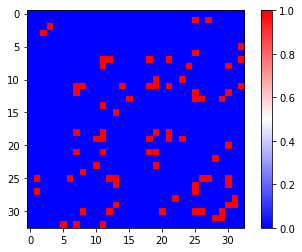

In [73]:
plt.imshow(GBC_Cov_Mat - np.diag(np.diag(GBC_Cov_Mat)) > 3e-3,  cmap = 'bwr')
plt.colorbar()

In [83]:
GS_C_corr_graph = nx.Graph()
r_idx, c_idx = np.where(GBC_Cov_Mat - np.diag(np.diag(GBC_Cov_Mat)) >3e-3)
GS_C_corr_graph.add_edges_from([(prom_green_skills[r_idx[j]], prom_green_skills[c]) for j, c in enumerate(c_idx) if r_idx[j] > c])

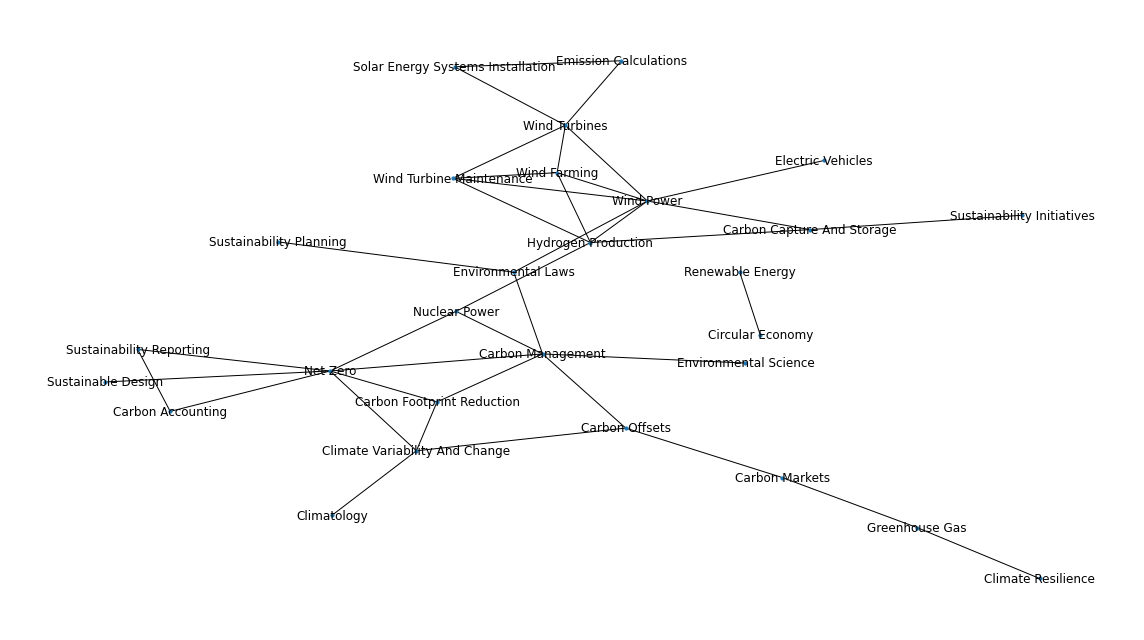

In [84]:
pos = nx.kamada_kawai_layout(GS_C_corr_graph)
fig, ax = plt.subplots(1,1, figsize = [16,9])
nx.draw(GS_C_corr_graph, node_size =10, pos= pos, with_labels= True, ax = ax)
fig.tight_layout()

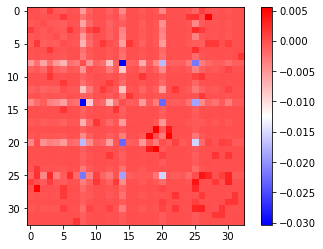

In [366]:
n_components = 6
LDA = LatentDirichletAllocation(n_components = n_components )
LDA.fit(GB_Mat.T)

In [283]:
for row in LDA.components_:
    print(sorted([(sk, row[idx]/np.sum(row))  for idx, sk in enumerate(prom_green_skills)  if  row[idx] > 1.01/n_components ], key = lambda x : x[1], reverse = True))
    print('-------')

In [42]:
green_comp_green_job_counter = Counter(list(postings_data[renewable_energy_kws_comp_filter].COMPANY_NAME))
green_comp_total_job_counter= Counter(list(postings_data[postings_data.COMPANY_NAME.isin(green_comps)].COMPANY_NAME))

In [45]:
core_green_comps = [k for k, w in green_comp_green_job_counter.items() if w > 1]
peri_green_comps =  [k for k, w in green_comp_green_job_counter.items() if w== 1]

In [47]:
len(peri_green_comps), len(core_green_comps), len(green_comps)

In [73]:
all_green_jobs = postings_data[(renewable_energy_kws_filter > 1)]


peri_green_jobs = postings_data[postings_data.COMPANY_NAME.isin(peri_green_comps) & (renewable_energy_kws_filter > 1)]

core_green_jobs = postings_data[postings_data.COMPANY_NAME.isin(core_green_comps) & (renewable_energy_kws_filter > 1)]

In [59]:
sum(core_green_jobs.SOC_2.isnull()), sum(core_green_jobs.SOC_3.isnull()), sum(core_green_jobs.SOC_4.isnull())

In [122]:
for e in postings_data[(postings_data.COMPANY_NAME == 'Wwf')& (renewable_energy_kws_filter > 1)].JOB_DESCRIPTION:
    print(e)

In [106]:
SOC_2_core_green_company_count = core_green_jobs[['COMPANY_NAME', 'SOC_2_NAME']].groupby('SOC_2_NAME').count()
SOC_3_core_green_company_count = core_green_jobs[['COMPANY_NAME', 'SOC_3_NAME']].groupby('SOC_3_NAME').count()
SOC_4_core_green_company_count = core_green_jobs[['COMPANY_NAME', 'SOC_4_NAME']].groupby('SOC_4_NAME').count()

In [107]:
SOC_2_all_comp_count = postings_data[['COMPANY_NAME', 'SOC_2_NAME']].groupby('SOC_2_NAME').count()
SOC_3_all_comp_count = postings_data[['COMPANY_NAME', 'SOC_3_NAME']].groupby('SOC_3_NAME').count()
SOC_4_all_comp_count = postings_data[['COMPANY_NAME', 'SOC_4_NAME']].groupby('SOC_4_NAME').count()

In [108]:
SOC_2_green_comp_frac = {s: SOC_2_core_green_company_count.loc[s].item()/SOC_2_all_comp_count.loc[s].item() for s in SOC_2_core_green_company_count.index}
SOC_3_green_comp_frac = {s: SOC_3_core_green_company_count.loc[s].item()/SOC_3_all_comp_count.loc[s].item() for s in SOC_3_core_green_company_count.index}
SOC_4_green_comp_frac = {s: SOC_4_core_green_company_count.loc[s].item()/SOC_4_all_comp_count.loc[s].item() for s in SOC_4_core_green_company_count.index}

In [109]:
print(sorted([(k,w*100) for k,w in SOC_2_green_comp_frac.items()], key = lambda x: x[1], reverse = True))
print('======')
print(sorted([(k,w*100) for k,w in SOC_3_green_comp_frac.items()], key = lambda x: x[1], reverse = True))
print('======')
print(sorted([(k,w*100) for k,w in SOC_4_green_comp_frac.items()], key = lambda x: x[1], reverse = True))


In [69]:
Counter(list(core_green_jobs['SOC_3_NAME']))

In [51]:
for company_eg in core_green_comps:
    print(company_eg)
    for entry in postings_data.JOB_DESCRIPTION[postings_data.COMPANY_NAME == company_eg]:
        kw_intersect = [kw for kw in renewable_energy_kws if kw+ ' ' in entry]
        if len(kw_intersect) > 1:
            print(kw_intersect)
            #print(entry)

            print('----')
    print('================')

In [ ]:
print('False positive with sustainable keyword')
company_eg = "Everton Football Club"
for entry in postings_data.JOB_DESCRIPTION[postings_data.COMPANY_NAME == company_eg]:
    #print(set(entry.replace('\n', ' ').split(' ')).intersection(renewable_energy_kws))
    print([kw for kw in false_positive_kws if kw in entry])
    print('----')

In [ ]:
company_eg = "Yo! Sushi"
for entry in postings_data.JOB_DESCRIPTION[(postings_data.COMPANY_NAME == company_eg) & renewable_energy_kws_filter]:
    #print(set(entry.replace('\n', ' ').split(' ')).intersection(renewable_energy_kws))
    print([kw for kw in renewable_energy_kws if kw in entry])
    print(entry)
    print('----')

In [ ]:
print('False positive with sustainable keyword')
company_eg = "Thomas Cook"
for entry in postings_data.JOB_DESCRIPTION[(postings_data.COMPANY_NAME == company_eg) & renewable_energy_kws_filter]:
    #print(set(entry.replace('\n', ' ').split(' ')).intersection(renewable_energy_kws))
    print([kw for kw in renewable_energy_kws if kw in entry])
    print(entry)
    print('----')

In [ ]:
list(green_comps)

In [147]:
spec_skills = postings_data['SPECIALIZED_SKILLS_NAME']
comm_skills = postings_data['COMMON_SKILLS_NAME']
sw_skills = postings_data['SOFTWARE_SKILLS_NAME']

In [148]:
spec_skill_split = [s[4:-2].replace('"', '').split(',\n  ') for s in spec_skills if len(s) > 3 ]
comm_skill_split = [s[4:-2].replace('"', '').split(',\n  ') for s in comm_skills if len(s) > 3 ]
sw_skill_split = [s[4:-2].replace('"', '').split(',\n  ') for s in sw_skills if len(s) > 3 ]

spec_skill_counts = Counter([sk for joblst in spec_skill_split for sk in joblst])
comm_skill_counts = Counter([sk for joblst in comm_skill_split for sk in joblst])
sw_skill_counts = Counter([sk for joblst in sw_skill_split for sk in joblst])

In [133]:
len(comm_skill_counts), len(spec_skill_counts), len(sw_skill_counts)

In [ ]:
skill_cnt_distr = np.quantile(np.array(list(spec_skill_counts.values())), np.linspace(0,1, 101))

In [ ]:
skill_cnt_distr[25], skill_cnt_distr[50], skill_cnt_distr[99], skill_cnt_distr[99]

In [ ]:
plt.semilogx(skill_cnt_distr, np.linspace(0,1, 101))
plt.ylabel('Cumulative distribution')
plt.xlabel('No. of jobs referencing skill')
plt.savefig('Skill_freq.pdf', dpi = 300)

In [ ]:
q95_spec_skills_counts =[(k,w) for k,w in spec_skill_counts.items() if w > 155]
q25_spec_skills_counts =[(k,w) for k,w in spec_skill_counts.items() if w < 3]

In [ ]:
q25_spec_skills_counts 

In [ ]:
q99_spec_skills_counts =[(k,w) for k,w in spec_skill_count.items() if w > 561]


In [ ]:
print(q99_spec_skills_counts)